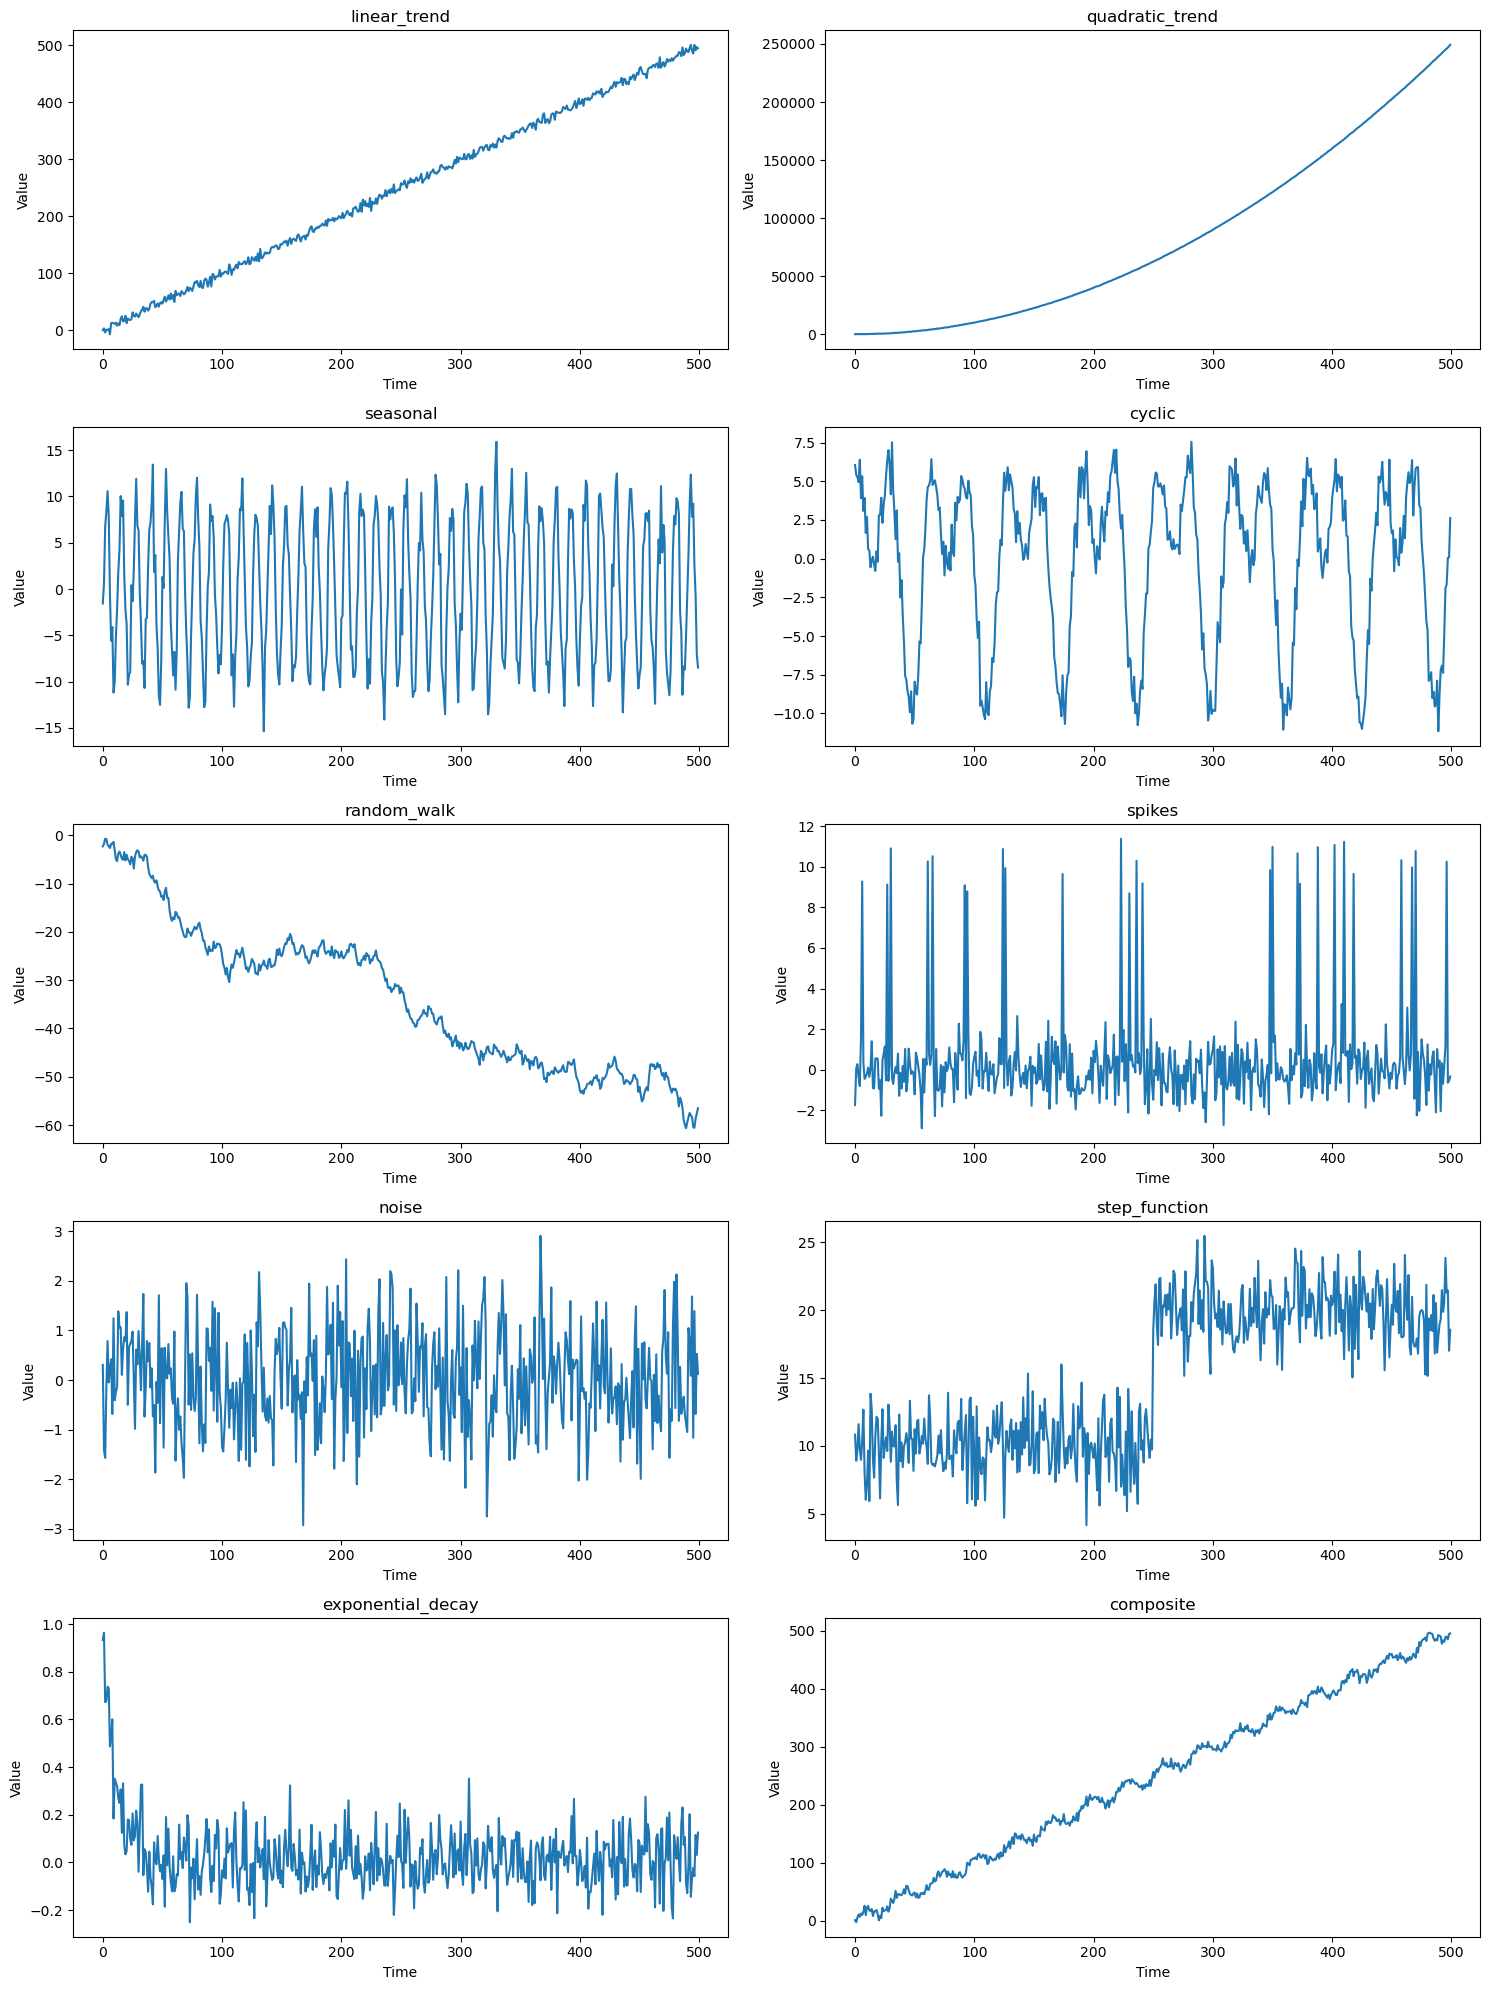

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 시계열 데이터 생성 함수
def generate_time_series_data(num_points=500):
    t = np.arange(num_points)
    data = {
        'linear_trend': t + np.random.normal(0, 5, num_points),
        'quadratic_trend': t**2 + np.random.normal(0, 100, num_points),
        'seasonal': 10 * np.sin(t / 2) + np.random.normal(0, 2, num_points),
        'cyclic': 5 * np.sin(t / 10) + 5 * np.cos(t / 5) + np.random.normal(0, 1, num_points),
        'random_walk': np.cumsum(np.random.normal(0, 1, num_points)),
        'spikes': np.random.normal(0, 1, num_points) + (np.random.choice([0, 10], num_points, p=[0.95, 0.05])),
        'noise': np.random.normal(0, 1, num_points),
        'step_function': np.piecewise(t, [t < num_points/2, t >= num_points/2], [10, 20]) + np.random.normal(0, 2, num_points),
        'exponential_decay': np.exp(-t / 10) + np.random.normal(0, 0.1, num_points),
        'composite': t + 10 * np.sin(t / 5) + np.random.normal(0, 5, num_points)
    }
    df = pd.DataFrame(data)
    return df

# 데이터 생성
num_points = 500
df = generate_time_series_data(num_points)

# 원시 데이터 플롯
plt.figure(figsize=(15, 20))
for i, column in enumerate(df.columns):
    plt.subplot(2, 5, i + 1)
    plt.plot(df[column])
    plt.title(column)
    plt.xlabel('Time')
    plt.ylabel('Value')
plt.tight_layout()
plt.show()

# 시계열 데이터 시퀀스 생성 함수
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [2]:
# 모델 정의
class RNNModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, output_size=1, num_layers=1):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h_0 = torch.zeros(1, x.size(0), 50).to(x.device)
        out, _ = self.rnn(x, h_0)
        out = self.fc(out[:, -1, :])
        return out

class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, output_size=1, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h_0 = torch.zeros(1, x.size(0), 50).to(x.device)
        c_0 = torch.zeros(1, x.size(0), 50).to(x.device)
        out, _ = self.lstm(x, (h_0, c_0))
        out = self.fc(out[:, -1, :])
        return out

class GRUModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, output_size=1, num_layers=1):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h_0 = torch.zeros(1, x.size(0), 50).to(x.device)
        out, _ = self.gru(x, h_0)
        out = self.fc(out[:, -1, :])
        return out


In [3]:
# Training function
def train_model(model, dataloader, num_epochs=100, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for X_batch, y_batch in dataloader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss / len(dataloader)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')

# 평가 함수
def evaluate_model(model, data, seq_length, scaler):
    model.eval()
    predictions = []
    actuals = []
    criterion = nn.MSELoss()
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        actual = data[i + seq_length]
        with torch.no_grad():
            seq = torch.from_numpy(seq).float().unsqueeze(0)
            pred = model(seq).item()
        predictions.append(pred)
        actuals.append(actual)
    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
    actuals = scaler.inverse_transform(np.array(actuals).reshape(-1, 1)).flatten()
    mse = criterion(torch.tensor(predictions), torch.tensor(actuals)).item()
    return mse, actuals, predictions

# 시계열 데이터 분석 및 예측
def analyze_and_train_models(df):
    models = {
        'RNN': RNNModel(),
        'LSTM': LSTMModel(),
        'GRU': GRUModel()
    }
    
    results = {}
    predictions_dict = {}
    actuals_dict = {}
    
    for column in df.columns:
        print(f"Training models for {column} series...")
        
        data = df[column].values.reshape(-1, 1)
        scaler = MinMaxScaler()
        data = scaler.fit_transform(data)
        
        seq_length = 10
        X, y = create_sequences(data, seq_length)
        
        dataset = TensorDataset(torch.from_numpy(X).float(), torch.from_numpy(y).float())
        dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
        
        actuals_dict[column] = scaler.inverse_transform(data).flatten()
        
        for model_name, model in models.items():
            print(f'Training {model_name} model for {column} series...')
            train_model(model, dataloader)
            mse, actuals, predictions = evaluate_model(model, data, seq_length, scaler)
            results[f'{column}_{model_name}'] = mse
            predictions_dict[f'{column}_{model_name}'] = predictions
            
    return actuals_dict, predictions_dict, results

# 모델 학습 및 예측
actuals_dict, predictions_dict, results = analyze_and_train_models(df)

Training models for linear_trend series...
Training RNN model for linear_trend series...
Epoch [1/100], Loss: 0.1870
Epoch [2/100], Loss: 0.0571
Epoch [3/100], Loss: 0.0297
Epoch [4/100], Loss: 0.0060
Epoch [5/100], Loss: 0.0014
Epoch [6/100], Loss: 0.0005
Epoch [7/100], Loss: 0.0003
Epoch [8/100], Loss: 0.0003
Epoch [9/100], Loss: 0.0003
Epoch [10/100], Loss: 0.0003
Epoch [11/100], Loss: 0.0002
Epoch [12/100], Loss: 0.0002
Epoch [13/100], Loss: 0.0003
Epoch [14/100], Loss: 0.0003
Epoch [15/100], Loss: 0.0003
Epoch [16/100], Loss: 0.0002
Epoch [17/100], Loss: 0.0002
Epoch [18/100], Loss: 0.0002
Epoch [19/100], Loss: 0.0002
Epoch [20/100], Loss: 0.0002
Epoch [21/100], Loss: 0.0002
Epoch [22/100], Loss: 0.0002
Epoch [23/100], Loss: 0.0002
Epoch [24/100], Loss: 0.0002
Epoch [25/100], Loss: 0.0002
Epoch [26/100], Loss: 0.0002
Epoch [27/100], Loss: 0.0002
Epoch [28/100], Loss: 0.0002
Epoch [29/100], Loss: 0.0002
Epoch [30/100], Loss: 0.0002
Epoch [31/100], Loss: 0.0002
Epoch [32/100], Loss:

/tmp/ipykernel_364490/2824027440.py:14: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_364490/2824027440.py:14: UserWarning: Glyph 44228 (\N{HANGUL SYLLABLE GYE}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_364490/2824027440.py:14: UserWarning: Glyph 50676 (\N{HANGUL SYLLABLE YEOL}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_364490/2824027440.py:14: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_364490/2824027440.py:14: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from current font.
  plt.tight_layout()
/home/spiders22v/miniconda3/envs/py311_pt231/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/spiders22v/miniconda3/envs/py311_pt231/lib/python3.11/site-packages/IPytho

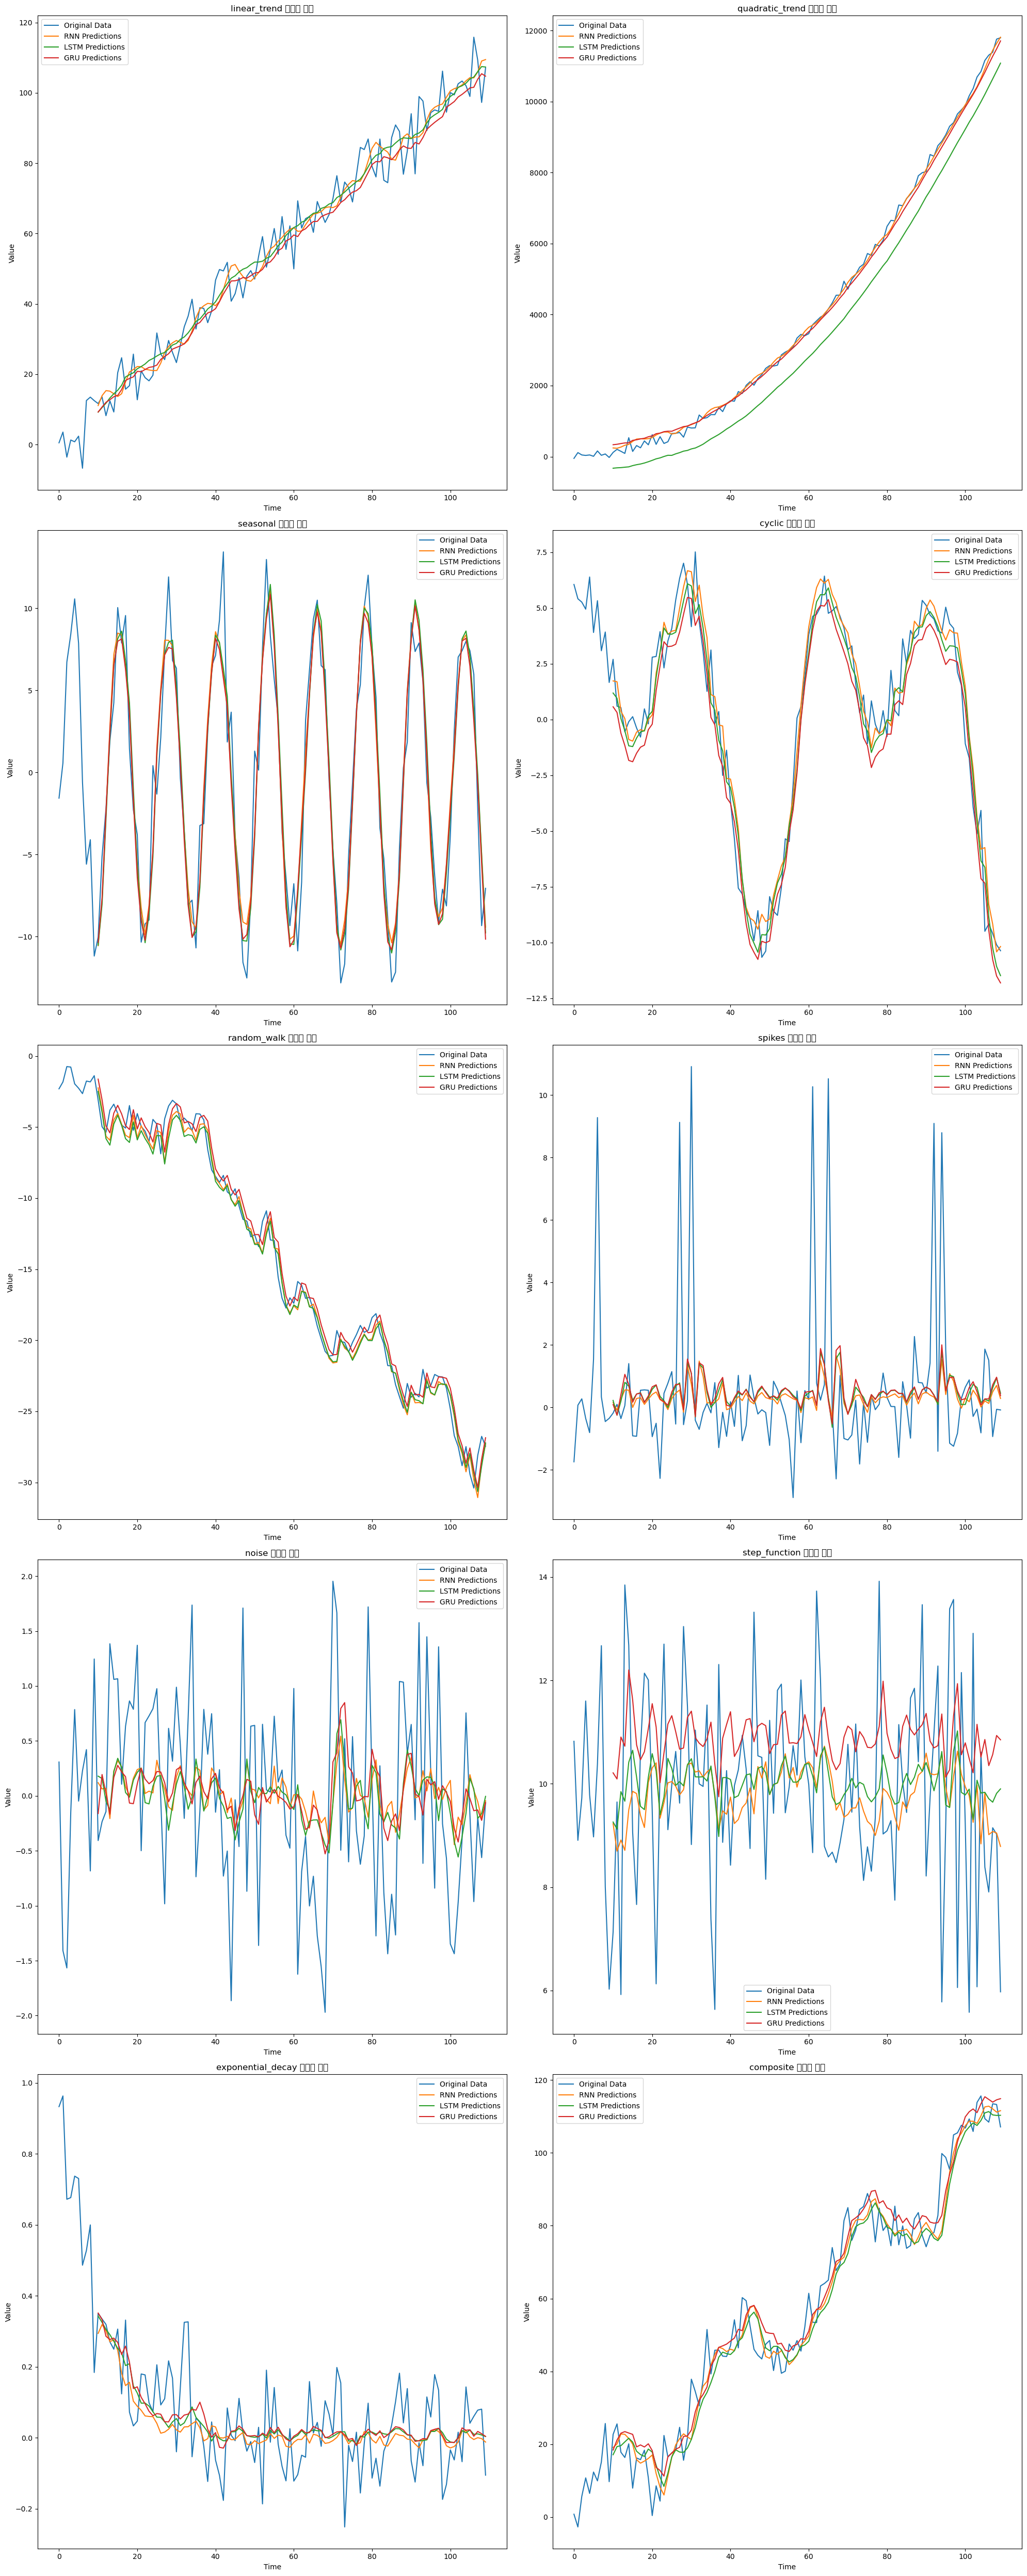

Mean Squared Error (MSE) for each model:
linear_trend_RNN: 35.62866311797349
linear_trend_LSTM: 27.976250387417544
linear_trend_GRU: 31.893848158873784
quadratic_trend_RNN: 45299.987747553896
quadratic_trend_LSTM: 302168.5045738864
quadratic_trend_GRU: 23880.69046004704
seasonal_RNN: 4.563271026190267
seasonal_LSTM: 4.556425675223353
seasonal_GRU: 4.724236727493714
cyclic_RNN: 1.5804568906537078
cyclic_LSTM: 1.436754119098193
cyclic_GRU: 1.9745072375511334
random_walk_RNN: 1.3627658176342776
random_walk_LSTM: 1.1251741344380877
random_walk_GRU: 1.0293899439491574
spikes_RNN: 5.881227559190843
spikes_LSTM: 5.862094630171347
spikes_GRU: 5.851426060452967
noise_RNN: 0.8942083305698146
noise_LSTM: 0.8952217695202073
noise_GRU: 0.8540312838520037
step_function_RNN: 5.076270709843418
step_function_LSTM: 4.843251675500742
step_function_GRU: 5.13767282803678
exponential_decay_RNN: 0.010554542267367944
exponential_decay_LSTM: 0.010392980001997313
exponential_decay_GRU: 0.010221115865988159
comp

In [4]:
# 예측 결과 시각화
plt.figure(figsize=(20, 50))
for i, column in enumerate(df.columns):
    plt.subplot(5, 2, i + 1)
    plt.plot(actuals_dict[column][:110], label='Original Data')
    plt.plot(range(10, 110), predictions_dict[f'{column}_RNN'][:100], label='RNN Predictions')
    plt.plot(range(10, 110), predictions_dict[f'{column}_LSTM'][:100], label='LSTM Predictions')
    plt.plot(range(10, 110), predictions_dict[f'{column}_GRU'][:100], label='GRU Predictions')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title(f'{column} 시계열 예측')

plt.tight_layout()
plt.show()

# 결과 비교
print("Mean Squared Error (MSE) for each model:")
for model_name, mse in results.items():
    print(f'{model_name}: {mse}')